In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

import missingno as msno

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
import xgboost as xgb
import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns

print('얍💢')

얍💢


# 데이터불러오기 

In [2]:
data_dir = os.getenv('HOME')+'/aiffel/kaggle/data'

train_data_path = join(data_dir, 'sales_train.csv')
test_data_path = join(data_dir, 'test.csv')
sub_data_path = join(data_dir, 'sample_submission.csv')
itemca_data_path = join(data_dir, 'item_categories.csv')
item_data_path = join(data_dir, 'items.csv')
shop_data_path = join(data_dir, 'shops.csv')

print(train_data_path)
print(test_data_path)
print(sub_data_path)
print(itemca_data_path)
print(item_data_path)
print(shop_data_path)

/home/ssac11/aiffel/kaggle/data/sales_train.csv
/home/ssac11/aiffel/kaggle/data/test.csv
/home/ssac11/aiffel/kaggle/data/sample_submission.csv
/home/ssac11/aiffel/kaggle/data/item_categories.csv
/home/ssac11/aiffel/kaggle/data/items.csv
/home/ssac11/aiffel/kaggle/data/shops.csv


In [3]:
train = pd.read_csv(train_data_path)
sub = pd.read_csv(sub_data_path)
test = pd.read_csv(test_data_path)
itemca = pd.read_csv(itemca_data_path)
item = pd.read_csv(item_data_path)
shop = pd.read_csv(shop_data_path)

# 데이터 확인하기 .    
+ 290만개의 데이터와 6개의 칼럼으로 구성되어 있습니다.
+ 칼럼
    + date : 날짜 
    + date_block_num:시작 달부터 순차적으로 진행
    + shop_id: 가게 number
    + item_price:아이템 가격
    + item_cnt_day:그날 아이템이 팔린 갯수

In [4]:
''' 함수를 만들었어요.
    데이터의 중복, 데이터형태 head, 칼럼과 데이터 타입, 결측치, '''
def basic_eda(df):
    print("---------중복값 체크------------")
    print(sum(df.duplicated()))
    print("----------TOP 5 RECORDS--------")
    print(df.head(5))
    print("----------INFO-----------------")
    print(df.info())
    print("----------Describe-------------")
    print(df.describe())
    print("----------Columns--------------")
    print(df.columns)
    print("----------Data Types-----------")
    print(df.dtypes)
    print("-------Missing Values----------")
    print(df.isnull().sum())
    print("-------NULL values-------------")
    print(df.isna().sum())
    print("-----Shape Of Data-------------")
    print(df.shape)

In [5]:
#중복이 있네요! 중복을 없애줘야 겠어요! 
#그 전에 중복이 진짜 똑같은 것인지 확인해 보도록 하겠습니다. 
basic_eda(train)

---------중복값 체크------------
6
----------TOP 5 RECORDS--------
         date  date_block_num  shop_id  item_id  item_price  item_cnt_day
0  02.01.2013               0       59    22154      999.00           1.0
1  03.01.2013               0       25     2552      899.00           1.0
2  05.01.2013               0       25     2552      899.00          -1.0
3  06.01.2013               0       25     2554     1709.05           1.0
4  15.01.2013               0       25     2555     1099.00           1.0
----------INFO-----------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
 #   Column          Dtype  
---  ------          -----  
 0   date            object 
 1   date_block_num  int64  
 2   shop_id         int64  
 3   item_id         int64  
 4   item_price      float64
 5   item_cnt_day    float64
dtypes: float64(2), int64(3), object(1)
memory usage: 134.4+ MB
None
----------Describe-------------
       date_block

In [6]:
#중복을 확인하도록 하겠습니다
train[train.duplicated()==True]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
76962,05.01.2013,0,54,20130,149.0,1.0
1435367,23.02.2014,13,50,3423,999.0,1.0
1496766,23.03.2014,14,21,3423,999.0,1.0
1671873,01.05.2014,16,50,3423,999.0,1.0
1866340,12.07.2014,18,25,3423,999.0,1.0
2198566,31.12.2014,23,42,21619,499.0,1.0


진짜 중복이네요...지울게요.
+ 중복 여부 확인 : DataFrame.duplicated()
+ 중복이 있으면 처음과 마지막 값 중 무엇을 남길 것인가? : keep = 'first', 'last', False
+ 중복값 처리(unique한 1개의 key만 남기고 나머지 중복은 제거) : DataFrame.drop_duplicates()

In [7]:
train.drop_duplicates(inplace=True)# 중복제거 
sum(train.duplicated())

0

In [8]:
basic_eda(test)

---------중복값 체크------------
0
----------TOP 5 RECORDS--------
   ID  shop_id  item_id
0   0        5     5037
1   1        5     5320
2   2        5     5233
3   3        5     5232
4   4        5     5268
----------INFO-----------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214200 entries, 0 to 214199
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype
---  ------   --------------   -----
 0   ID       214200 non-null  int64
 1   shop_id  214200 non-null  int64
 2   item_id  214200 non-null  int64
dtypes: int64(3)
memory usage: 4.9 MB
None
----------Describe-------------
                  ID        shop_id        item_id
count  214200.000000  214200.000000  214200.000000
mean   107099.500000      31.642857   11019.398627
std     61834.358168      17.561933    6252.644590
min         0.000000       2.000000      30.000000
25%     53549.750000      16.000000    5381.500000
50%    107099.500000      34.500000   11203.000000
75%    160649.250000      47.000000

In [9]:
basic_eda(sub)

---------중복값 체크------------
0
----------TOP 5 RECORDS--------
   ID  item_cnt_month
0   0             0.5
1   1             0.5
2   2             0.5
3   3             0.5
4   4             0.5
----------INFO-----------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214200 entries, 0 to 214199
Data columns (total 2 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   ID              214200 non-null  int64  
 1   item_cnt_month  214200 non-null  float64
dtypes: float64(1), int64(1)
memory usage: 3.3 MB
None
----------Describe-------------
                  ID  item_cnt_month
count  214200.000000        214200.0
mean   107099.500000             0.5
std     61834.358168             0.0
min         0.000000             0.5
25%     53549.750000             0.5
50%    107099.500000             0.5
75%    160649.250000             0.5
max    214199.000000             0.5
----------Columns--------------
Index(['ID', 'item_cnt_month

In [10]:
basic_eda(itemca)

---------중복값 체크------------
0
----------TOP 5 RECORDS--------
        item_category_name  item_category_id
0  PC - Гарнитуры/Наушники                 0
1         Аксессуары - PS2                 1
2         Аксессуары - PS3                 2
3         Аксессуары - PS4                 3
4         Аксессуары - PSP                 4
----------INFO-----------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84 entries, 0 to 83
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   item_category_name  84 non-null     object
 1   item_category_id    84 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 1.4+ KB
None
----------Describe-------------
       item_category_id
count         84.000000
mean          41.500000
std           24.392622
min            0.000000
25%           20.750000
50%           41.500000
75%           62.250000
max           83.000000
----------Columns--------------
Index([

In [11]:
basic_eda(item)

---------중복값 체크------------
0
----------TOP 5 RECORDS--------
                                           item_name  item_id  \
0          ! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.)         D        0   
1  !ABBYY FineReader 12 Professional Edition Full...        1   
2      ***В ЛУЧАХ СЛАВЫ   (UNV)                    D        2   
3    ***ГОЛУБАЯ ВОЛНА  (Univ)                      D        3   
4        ***КОРОБКА (СТЕКЛО)                       D        4   

   item_category_id  
0                40  
1                76  
2                40  
3                40  
4                40  
----------INFO-----------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22170 entries, 0 to 22169
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   item_name         22170 non-null  object
 1   item_id           22170 non-null  int64 
 2   item_category_id  22170 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 519

In [12]:
basic_eda(shop)

---------중복값 체크------------
0
----------TOP 5 RECORDS--------
                        shop_name  shop_id
0   !Якутск Орджоникидзе, 56 фран        0
1   !Якутск ТЦ "Центральный" фран        1
2                Адыгея ТЦ "Мега"        2
3  Балашиха ТРК "Октябрь-Киномир"        3
4        Волжский ТЦ "Волга Молл"        4
----------INFO-----------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   shop_name  60 non-null     object
 1   shop_id    60 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 1.1+ KB
None
----------Describe-------------
         shop_id
count  60.000000
mean   29.500000
std    17.464249
min     0.000000
25%    14.750000
50%    29.500000
75%    44.250000
max    59.000000
----------Columns--------------
Index(['shop_name', 'shop_id'], dtype='object')
----------Data Types-----------
shop_name    object
shop_id       int6

# 데이터 전처리 
1) 중복제거 

2) object형태 변환 > float pd.to_datetime()

3) outliner 제거 

4) cnt day, item price 마이너스 제거 (반품이기에 판매를 예측하는데 필요가 없어 보입니다.)

In [13]:
#train에서 date가 object형이기에 형태를 변화시켜 줍니다. 
train2 = train
train2['date'] = pd.to_datetime(train2['date'])
train2['date'] = train2['date'].dt.date

In [14]:
# 데이터가 어떻게 생겼는지 시각화 작업을 해보았습니다. 

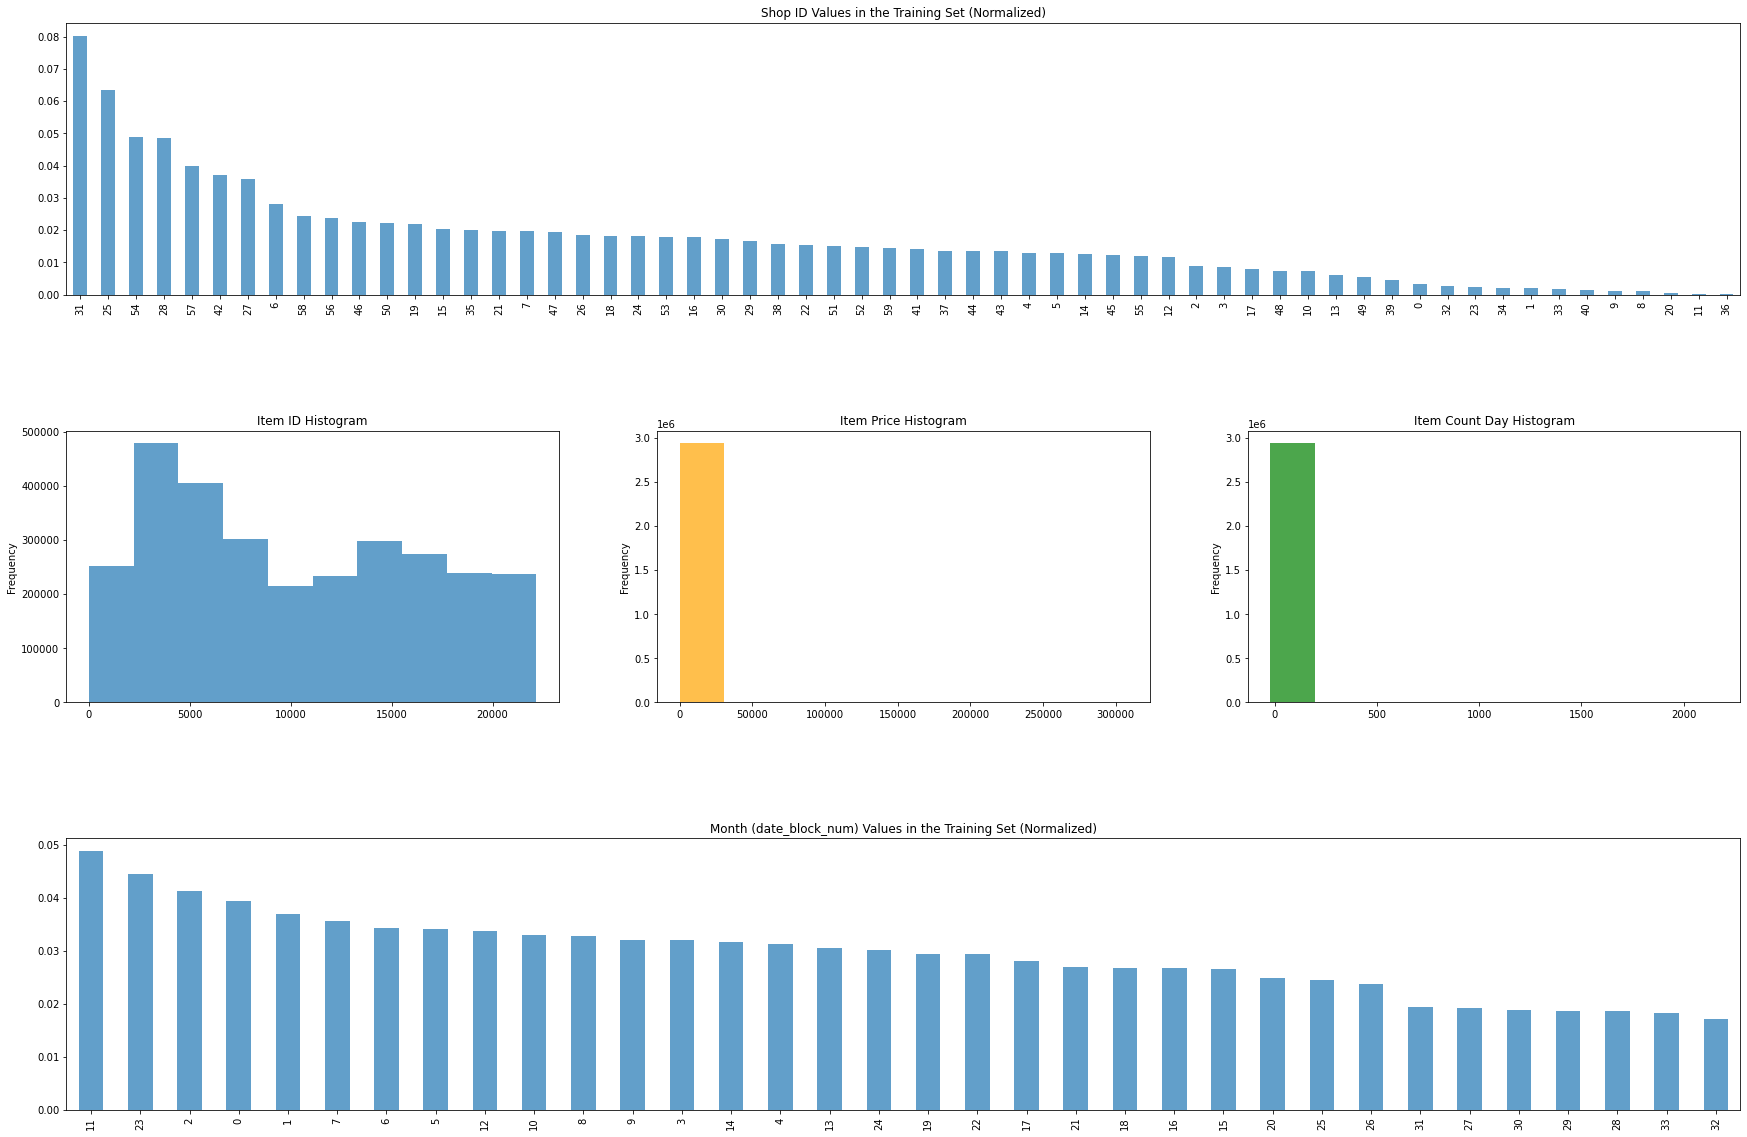

In [15]:
fig = plt.figure(figsize=(30,20))
plt.subplots_adjust(hspace=0.5) #hspace 옵션은 subplot사이의 공간을 얼만큼 둘것인가를 나타냅니다. 

plt.subplot2grid((3,3), (0,0), colspan = 5) # subplot2grid는 일반 그리드 내의 특정 위치에 축을 만들어 냅니다. colspan옵션은 축이 아래쪽으로 확장되는 열의 수를 나타냅니다.
train['shop_id'].value_counts(normalize=True).plot(kind='bar', alpha=0.7)#normalize를 해주면 2만개가 넘던게 0,08이 최대로 변합니다. 
plt.title('Shop ID Values in the Training Set (Normalized)')

plt.subplot2grid((3,3), (1,0))
train['item_id'].plot(kind='hist', alpha=0.7)#여기서는 hist로 나타낸 이유가 일단 모르겠으면 histo가 편합니다. 얼마나 쌓여있는지 어디에 값이 편향되어있는지 확인하기 좋습니다. 
plt.title('Item ID Histogram')

plt.subplot2grid((3,3), (1,1))
train['item_price'].plot(kind='hist', alpha=0.7, color='orange')#대부분의 값들이 만개정도..?까지 있는것같은데 더 자세히 찍어서 이상치를 확인하는게 좋을 듯합니다. 
plt.title('Item Price Histogram')

plt.subplot2grid((3,3), (1,2))
train['item_cnt_day'].plot(kind='hist', alpha=0.7, color='green')#애도 이상치가 있어보이네요. 값이 편향되어 있습니다. 
plt.title('Item Count Day Histogram')

plt.subplot2grid((3,3), (2,0), colspan = 3) #시작일부터 월별 추이를 나타냅니다. 음...판매량이 점점 떨어지네요..
train['date_block_num'].value_counts(normalize=True).plot(kind='bar', alpha=0.7)
plt.title('Month (date_block_num) Values in the Training Set (Normalized)')

plt.show()

<AxesSubplot:xlabel='item_price'>

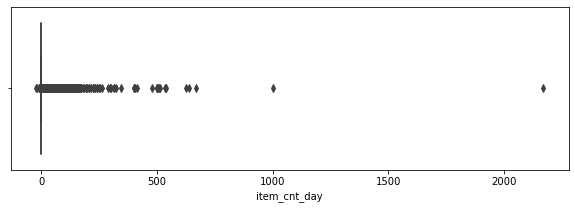

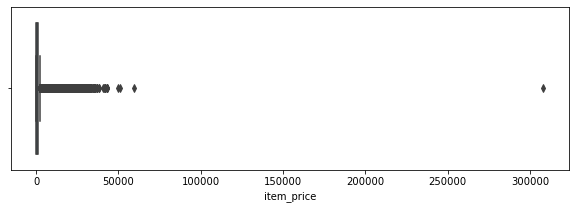

In [16]:
# date_block_num. shop_id와 같이 다른 칼럼은 카테고리형이기에 따로 아웃라이어를 확인하지 않았습니다. 
plt.figure(figsize=(10,3))
sns.boxplot(x='item_cnt_day', data= train)

plt.figure(figsize=(10,3))
sns.boxplot(x='item_price', data = train)

In [17]:
# 이상치를 제거합니다. 
train = train[train.item_cnt_day < 500]
train = train[train.item_price < 50000]

<AxesSubplot:xlabel='item_price'>

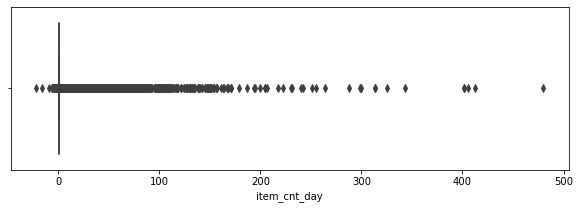

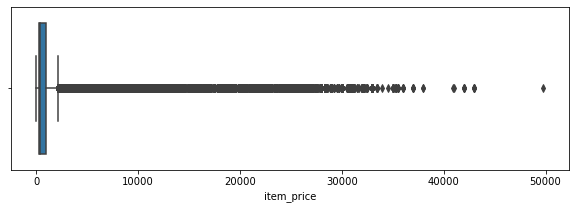

In [18]:
#제거되었는지 확인해 보았습니다. 
plt.figure(figsize=(10,3))
sns.boxplot(x='item_cnt_day', data= train)

plt.figure(figsize=(10,3))
sns.boxplot(x='item_price', data = train)

In [19]:
# 반품처리되어있는거를 적절하게 수정하도록 하겠습니다. 
# 반품이라면 그전에 판매로 잡혀있는 데이터가 있지만..현재 그 데이터를 찾기가 어렵기에 일단은 마이너스데이터만 처리하도록 하겠습니다. 
train = train[train.item_cnt_day >= 0]
train = train[train.item_price >= 0]

<AxesSubplot:xlabel='item_price'>

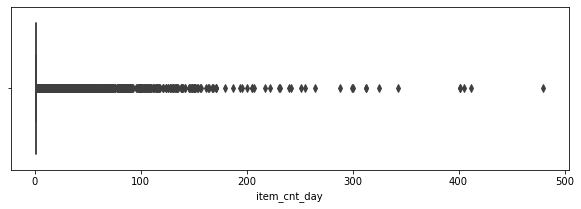

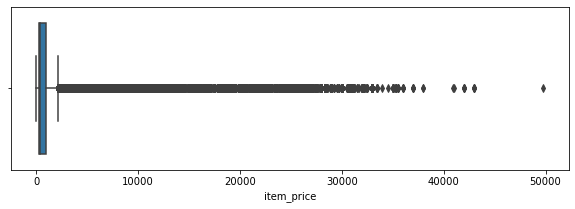

In [20]:
plt.figure(figsize=(10,3))
sns.boxplot(x='item_cnt_day', data= train)

plt.figure(figsize=(10,3))
sns.boxplot(x='item_price', data = train)

In [21]:
#0미만의 데이터가 사라졌습니다! 

In [22]:
# shop이름을 확인해보도록 하겠습니다. 
# 있는 데이터는 다 활용해봐야 하니깐요! 이름에서 좋은 의미를 가지는 칼럼을 생성할지도 모르잖아요. 

In [23]:
shop.head(40)

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4
5,"Вологда ТРЦ ""Мармелад""",5
6,"Воронеж (Плехановская, 13)",6
7,"Воронеж ТРЦ ""Максимир""",7
8,"Воронеж ТРЦ Сити-Парк ""Град""",8
9,Выездная Торговля,9


In [24]:
#스토어 이름을 찍어보니 앞쪽에서 유사한 패턴이 보입니다.
#26,27,28,29가 같은 유사하네요. 
#이게 맞는지는 모르겠지만 일단 앞쪽을 기준으로 이름이라고 생각하고......빼 볼게요.

In [25]:
 shop['name'] = shop['shop_name'].str.split(' ').map(lambda x: x[0])

#이렇게 하면 shops에 name이라는 칼럼이 추가되고 그거는 split()으로 찍고 mapping 했으니깐 첫문자만 나올 듯하네요.
shop.head ()

,shop_name,shop_id,name
0,"!Якутск Орджоникидзе, 56 фран",0,!Якутск
1,"!Якутск ТЦ ""Центральный"" фран",1,!Якутск
2,"Адыгея ТЦ ""Мега""",2,Адыгея
3,"Балашиха ТРК ""Октябрь-Киномир""",3,Балашиха
4,"Волжский ТЦ ""Волга Молл""",4,Волжский


In [26]:
shop.info() #object형태가 생겼다..이거를 처리를 해줘야한다. 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   shop_name  60 non-null     object
 1   shop_id    60 non-null     int64 
 2   name       60 non-null     object
dtypes: int64(1), object(2)
memory usage: 1.5+ KB


In [28]:
len(shop['name'].unique()) # 32개로 줄여진게 음..labelencording 해줘도 좋겠다. 

32

In [30]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
shop['name'] = le.fit_transform(shop['name'])
shop.head()

,shop_name,shop_id,name
0,"!Якутск Орджоникидзе, 56 фран",0,0
1,"!Якутск ТЦ ""Центральный"" фран",1,0
2,"Адыгея ТЦ ""Мега""",2,1
3,"Балашиха ТРК ""Октябрь-Киномир""",3,2
4,"Волжский ТЦ ""Волга Молл""",4,3


In [31]:
#피벗 테이블을 만들어보도록 하겠습니다. 
#한달 동안 한 상점에 대한 항목의 총 판매량을 알고 싶습니다. 
#그래서 shop_id와 item_id를 인덱스로 만들고 date_block_num을 칼럼으로 만듭니다. 
#원하는건!!! item_cnt_day이고 총량을 찾으면 되겠쮸? 
dataset = train.pivot_table(index = ['shop_id','item_id'],values = ['item_cnt_day'],columns = ['date_block_num'],fill_value = 0,aggfunc='sum')
dataset

item_cnt_day                              ...                 \
date_block_num            0   1  2  3  4  5  6  7  8  9   ... 24 25 26 27 28   
shop_id item_id                                           ...                  
0       30                 0  31  0  0  0  0  0  0  0  0  ...  0  0  0  0  0   
        31                 0  11  0  0  0  0  0  0  0  0  ...  0  0  0  0  0   
        32                 6  10  0  0  0  0  0  0  0  0  ...  0  0  0  0  0   
        33                 3   3  0  0  0  0  0  0  0  0  ...  0  0  0  0  0   
        35                 1  14  0  0  0  0  0  0  0  0  ...  0  0  0  0  0   
...                      ...  .. .. .. .. .. .. .. .. ..  ... .. .. .. .. ..   
59      22154              1   0  0  0  0  0  0  0  0  0  ...  0  0  0  0  0   
        22155              0   0  0  0  0  0  1  0  0  0  ...  0  0  0  0  0   
        22162              0   0  0  0  0  0  0  0  0  0  ...  0  9  4  1  1   
        22164              0   0  0  0  0  0  0  0  0  0  ...  0  2  1  2  0   
        22167              0   0  0  0  0  0  0  0  0  1  ...  0  0  0  0  0   

                                
date_block_num  29 30 31 32 33  
shop_id item_id                 
0       30       0  0  0  0  0  
        31       0  0  0  0  0  
        32       0  0  0  0  0  
        33       0  0  0  0  0  
        35       0  0  0  0  0  
...             .. .. .. .. ..  
59      22154    0  0  0  0  0  
        22155    0  0  0  0  0  
        22162    0  0  1  0  0  
        22164    0  1  0  0  0  
        22167    0  0  0  0  0  

[424095 rows x 34 columns]

In [32]:
#인덱스를 조정해서 조금 더 보기 편하게 만듭니다. 
dataset.reset_index(inplace = True)
dataset.tail()

shop_id item_id item_cnt_day                       ...        \
date_block_num                            0  1  2  3  4  5  6  7  ... 24 25   
424090              59   22154            1  0  0  0  0  0  0  0  ...  0  0   
424091              59   22155            0  0  0  0  0  0  1  0  ...  0  0   
424092              59   22162            0  0  0  0  0  0  0  0  ...  0  9   
424093              59   22164            0  0  0  0  0  0  0  0  ...  0  2   
424094              59   22167            0  0  0  0  0  0  0  0  ...  0  0   

                                        
date_block_num 26 27 28 29 30 31 32 33  
424090          0  0  0  0  0  0  0  0  
424091          0  0  0  0  0  0  0  0  
424092          4  1  1  0  0  1  0  0  
424093          1  2  0  0  1  0  0  0  
424094          0  0  0  0  0  0  0  0  

[5 rows x 36 columns]

In [33]:
# train['date_block_num'] # 판매개월수를 나타냅니다. 자꾸 까먹네요..
#items의 길이는 22170개의 데이터가 들어있네요. 
#엄청나게 sparse힌 매트릭스가 나왔군요. 이럴경우는  csr을 사용하여 메모리를 줄일 수 있어요.
test

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268
...,...,...,...
214195,214195,45,18454
214196,214196,45,16188
214197,214197,45,15757
214198,214198,45,19648


In [34]:
#엄청나게..sparse한 매트릭스가 나오는군요. 
#이제 피벗테이블과 test데이터를 merge하도록 하겠습니다. 
dataset = pd.merge(test,dataset,on =['item_id','shop_id'],how = 'left')
#item_id와 shop_id를 기준으로 testdata와 dataset을 왼쪽 정렬로 merge해주세요! 
dataset

,ID,shop_id,item_id,"(item_cnt_day, 0)","(item_cnt_day, 1)","(item_cnt_day, 2)","(item_cnt_day, 3)","(item_cnt_day, 4)","(item_cnt_day, 5)","(item_cnt_day, 6)",...,"(item_cnt_day, 24)","(item_cnt_day, 25)","(item_cnt_day, 26)","(item_cnt_day, 27)","(item_cnt_day, 28)","(item_cnt_day, 29)","(item_cnt_day, 30)","(item_cnt_day, 31)","(item_cnt_day, 32)","(item_cnt_day, 33)"
0,0,5,5037,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,0.0,0.0,0.0,1.0,1.0,1.0,3.0,1.0,0.0
1,1,5,5320,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,5,5233,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,3.0,2.0,0.0,1.0,3.0,1.0
3,3,5,5232,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,4,5,5268,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
214195,214195,45,18454,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
214196,214196,45,16188,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
214197,214197,45,15757,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
214198,214198,45,19648,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [35]:
#결측치를 처리하도록 하겠습니다. 
dataset.fillna(0,inplace = True)
#여기서는 결측치를 0으로 처리하도록 하겠습니다. 
#데이터의 특성상 판매가 안되었다는 것을 의미하기 때문에 보통 사용하는 -1보다는 0으로 넣겠습니다. 
dataset.head()

,ID,shop_id,item_id,"(item_cnt_day, 0)","(item_cnt_day, 1)","(item_cnt_day, 2)","(item_cnt_day, 3)","(item_cnt_day, 4)","(item_cnt_day, 5)","(item_cnt_day, 6)",...,"(item_cnt_day, 24)","(item_cnt_day, 25)","(item_cnt_day, 26)","(item_cnt_day, 27)","(item_cnt_day, 28)","(item_cnt_day, 29)","(item_cnt_day, 30)","(item_cnt_day, 31)","(item_cnt_day, 32)","(item_cnt_day, 33)"
0,0,5,5037,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,0.0,0.0,0.0,1.0,1.0,1.0,3.0,1.0,0.0
1,1,5,5320,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,5,5233,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,3.0,2.0,0.0,1.0,3.0,1.0
3,3,5,5232,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,4,5,5268,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [36]:
#shop_id와 id, item_id는 학습을 할 때 중요한 정보는 아닌 듯하니 지우도록 하겠습니다. ########다시 확인하기!!!!!!!!
dataset.drop(['shop_id','item_id','ID'],inplace = True, axis = 1)
dataset.head()

,"(item_cnt_day, 0)","(item_cnt_day, 1)","(item_cnt_day, 2)","(item_cnt_day, 3)","(item_cnt_day, 4)","(item_cnt_day, 5)","(item_cnt_day, 6)","(item_cnt_day, 7)","(item_cnt_day, 8)","(item_cnt_day, 9)",...,"(item_cnt_day, 24)","(item_cnt_day, 25)","(item_cnt_day, 26)","(item_cnt_day, 27)","(item_cnt_day, 28)","(item_cnt_day, 29)","(item_cnt_day, 30)","(item_cnt_day, 31)","(item_cnt_day, 32)","(item_cnt_day, 33)"
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,0.0,0.0,0.0,1.0,1.0,1.0,3.0,1.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,3.0,2.0,0.0,1.0,3.0,1.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [37]:
# X we will keep all columns execpt the last one 
X_train = np.expand_dims(dataset.values[:,:-1],axis = 2)
# the last column is our label
y_train = dataset.values[:,-1:]

# for test we keep all the columns execpt the first one
X_test = np.expand_dims(dataset.values[:,1:],axis = 2)

# lets have a look on the shape 
print(X_train.shape,y_train.shape,X_test.shape)

(214200, 33, 1) (214200, 1) (214200, 33, 1)


In [38]:
##모델에 넣겠습니다. 
#첫 시도로 lstm과 dropout을 사용하도록 하겠습니다. 
from keras.models import Sequential
from keras.layers import LSTM,Dense,Dropout

In [39]:
my_model = Sequential()
my_model.add(LSTM(units = 64,input_shape = (33,1),return_sequences=True))
my_model.add(LSTM(units = 32, input_shape = (33,1),return_sequences= True))
my_model.add(Dropout(0.2))
my_model.add(Dense(1))

my_model.compile(loss = 'mse',optimizer = 'adam', metrics = ['mean_squared_error'])
my_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 33, 64)            16896     
_________________________________________________________________
lstm_1 (LSTM)                (None, 33, 32)            12416     
_________________________________________________________________
dropout (Dropout)            (None, 33, 32)            0         
_________________________________________________________________
dense (Dense)                (None, 33, 1)             33        
Total params: 29,345
Trainable params: 29,345
Non-trainable params: 0
_________________________________________________________________


In [40]:
my_model.fit(X_train,y_train,batch_size = 4096,epochs = 10)

Epoch 1/10
53/53 [==============================] - 1s 20ms/step - loss: 5.9060 - mean_squared_error: 5.9060
Epoch 2/10
53/53 [==============================] - 1s 19ms/step - loss: 5.7772 - mean_squared_error: 5.7772
Epoch 3/10
53/53 [==============================] - 1s 19ms/step - loss: 5.7092 - mean_squared_error: 5.7092
Epoch 4/10
53/53 [==============================] - 1s 19ms/step - loss: 5.6653 - mean_squared_error: 5.6653
Epoch 5/10
53/53 [==============================] - 1s 19ms/step - loss: 5.6331 - mean_squared_error: 5.6331
Epoch 6/10
53/53 [==============================] - 1s 19ms/step - loss: 5.6055 - mean_squared_error: 5.6055
Epoch 7/10
53/53 [==============================] - 1s 19ms/step - loss: 5.5770 - mean_squared_error: 5.5770
Epoch 8/10
53/53 [==============================] - 1s 19ms/step - loss: 5.5573 - mean_squared_error: 5.5573
Epoch 9/10
53/53 [==============================] - 1s 19ms/step - loss: 5.5296 - mean_squared_error: 5.5296
Epoch 10/10
53/53 [

In [41]:
# creating submission file 
submission_pfs = my_model.predict(X_test)
# we will keep every value between 0 and 20
submission_pfs = submission_pfs.clip(0,20)
# creating dataframe with required columns 
submission = pd.DataFrame({'ID':test['ID'],'item_cnt_month':submission_pfs.ravel()})
# creating csv file from dataframe
submission.to_csv('sub_pfs.csv',index = False)

ValueError: array length 7068600 does not match index length 214200

In [ ]:
#우리가 제출해야하는 submission의 모양도 확인해보겠습니다. 
sub.shape

In [ ]:
id_count = 